<h1 align="center"> Clustering and Comparsion of London and New York City - Code</h1>

Tim Chen

16th January 2021

##### Note: Detailed explanation is written in the report. This notebook contains complete code and brief explanation

# 1. Introduction

  London and New York City are two of the most influential and populous international cities in the world. As two megacities, London and New York City have diverse demographics and cultures, which contribute to their different neighborhoods and living experiences.
  
  In order to compare the unique living experience of the two cities, this project clusters the neighborhoods of London and New York City to give a comprehensive report of the difference and variety between their neighborhoods.

# 2. Business Problem

The purpose of this project is to provide a detailed comparison for those who are interested in learning about London and New York City. This project also helps tourists to make decisions about their destination depending on their preference of the neighborhoods. It is also a way for those who are considering migration to London or New York City to make their decisions. For investors and stakeholders, this project can provide them with more insights on the neighborhoods, and help them make decisions on their future investment locations.

# 3. Data Description

To make comparison between London and NYC, location (geographical) data is needed for both cities. To acquire detailed venue and neighborhood data, several other APIs are also needed for this project.

## 3.1  New York City Data

The data available for New York City can be found in the Json file located at https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json

The Json file contains all necessary informations of New York City for this project, including:

1. *Borough*: The name of the Borough (district) of NYC
2. *Neighborhood*: The name of neighborhoods of NYC
3. *Latitude*: The corresponding latitude of a specific neighborhood
4. *Longitude*: The corresponding longitude of a specific neighborhood

## 3.2 London Data

The data available for London can be found in the table of the wiki page https://en.wikipedia.org/wiki/List_of_areas_of_London.

The table contains borough and neighborhood data that needed for this project:

1. *Location*: The name of neighborhood of London
2. *London borough*: The name of borough (district) of London

However, longitude and latitude data for London neighborhood are not included in the wiki page. To solve this problem, we use the Geocoder Python package to derive those information.

## 3.3 Geocoder Python Package

Geocoder is a simple and consistent geocoding library written in Python. Dealing with multiple different geocoding provider such as Google, Bing, OSM & many more has never been easier.

Nominatim is a tool from Geocoder package that returns latitude and longitude of a specific location given its name. Using Nominatim, we are able to derive latitude and longitude data for London neighborhoods.

## 3.4 Foursquare API

After acquiring necessary neighborhood location data for both cities, we also need detailed venue data for those neighborhoods.

Foursquare is a social location service that allows users to explore the world around them. Foursquare API contains a massive dataset of accurate location data. It contains all sets of information needed for this project, including venue names, venue category, venue longitude, and venue latitude.

After collecting requisite latitude and longtitude data for all neighborhoods, we pass those information, with our credentials and maximum radius (we choose 500) to Foursquare API. Then, the API will provide us with the following information:

1. *Venue*: The name of a specific venue
2. *Venue Latitude*: The latitude of a specific venue
3. *Venue Longitude*: The longitude of a specific venue
4. *Venue Category*: The category of a specific venue, such as "Pizza Place" and "Coffee Shop"

A sample data derived from the API is shown below:

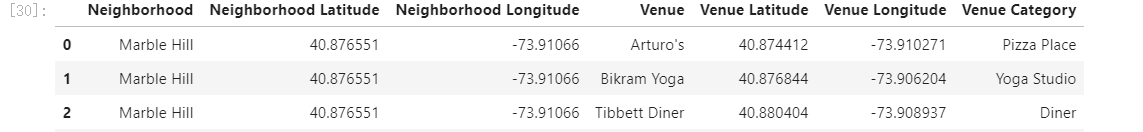

#  4. Methodology

## 4.1 Importing and Downloading Necessary Packages 

In [5]:
import pandas as pd 
import json 
!conda install -c conda-forge geopy --yes 

from geopy.geocoders import Nominatim 
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print('imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                                                            /failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - cffi -> python[version='2.7.*|3.5.*|3.6.*|3.6.12|3.6.12|>=3.6,<3.7.0a0|>=3.7,<3.8.0a0|>=3.9,<3.10.0a0|>=3.8,<3.9.0a0|3.7.9|3.6.9|3.6.9|3.6.9|>=2.7,<2.8.0a0|3.6.9|>=3.5,<3.6.0a0|3.4.*',build='2_73_pypy|4_73_pypy|5_73_pypy|3_73_pypy|1_73_pypy|0_73_pypy']
  - geopy -> python[version='2.7.*|3.4.*|3.5.*|3.6.*']
  - rs

     |████████████████████████████████| 94 kB 5.8 MB/s  eta 0:00:01
imported.


## 4.2 Data Collection
### 4.2.1. New York City

Download the Json file and load data

In [6]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [8]:
import json as json
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

All data needed for this project is in the features key, declare a new variable to save the data

In [9]:
nyc_neigh_data = newyork_data['features']
nyc_neigh_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transform the data into pandas dataframe

In [10]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
nyc_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyc_neigh_data:
    #get borough
    borough = data['properties']['borough'] 
    #get neighborhood name
    nyc_neighborhoods_name = data['properties']['name']
    #get latitude and longtitude    
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    #insert into the data frame
    nyc_neighborhoods= nyc_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': nyc_neighborhoods_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

nyc_neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

### 4.2.2. London

First, use requests to get all information from the wiki page

In [11]:
london_url = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London')

london_data = pd.read_html(london_url.text)
london_data

[                                                   0
 0  Map all coordinates in "Category:Areas of Lond...
 1                 Download coordinates as: KML · GPX,
             Location                     London borough       Post town  \
 0         Abbey Wood              Bexley, Greenwich [7]          LONDON   
 1              Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
 2          Addington                         Croydon[8]         CROYDON   
 3         Addiscombe                         Croydon[8]         CROYDON   
 4        Albany Park                             Bexley  BEXLEY, SIDCUP   
 ..               ...                                ...             ...   
 526         Woolwich                          Greenwich          LONDON   
 527   Worcester Park       Sutton, Kingston upon Thames  WORCESTER PARK   
 528  Wormwood Scrubs             Hammersmith and Fulham          LONDON   
 529          Yeading                         Hillingdon           HAYES   
 

The second table is the one we need

In [12]:
london_neigh= london_data[1]
london_neigh.head()

Location                     London borough       Post town  \
0   Abbey Wood              Bexley, Greenwich [7]          LONDON   
1        Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
2    Addington                         Croydon[8]         CROYDON   
3   Addiscombe                         Croydon[8]         CROYDON   
4  Albany Park                             Bexley  BEXLEY, SIDCUP   

  Postcode district Dial code OS grid ref  
0               SE2       020    TQ465785  
1            W3, W4       020    TQ205805  
2               CR0       020    TQ375645  
3               CR0       020    TQ345665  
4         DA5, DA14       020    TQ478728

## 4.3. Data Preprocessing
The two tables are created, but the names of their corresponding attributes are different. We need to change "Location" and "London borough" attributes to "Neighborhood" and "Borough". Then, we need to exchange the position of these two columns. We also need to remove "[]" for the second table.

Change column names

In [13]:
london_neigh.columns=['Neighborhood','Borough','Post_town','Postcode_district','Dial_code',"OS_grid_ref"]
london_neigh.head()

Neighborhood                            Borough       Post_town  \
0   Abbey Wood              Bexley, Greenwich [7]          LONDON   
1        Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
2    Addington                         Croydon[8]         CROYDON   
3   Addiscombe                         Croydon[8]         CROYDON   
4  Albany Park                             Bexley  BEXLEY, SIDCUP   

  Postcode_district Dial_code OS_grid_ref  
0               SE2       020    TQ465785  
1            W3, W4       020    TQ205805  
2               CR0       020    TQ375645  
3               CR0       020    TQ345665  
4         DA5, DA14       020    TQ478728

Remove "[]"

In [14]:
london_neigh['Borough'] = london_neigh['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))
london_neigh.head()

Neighborhood                         Borough       Post_town  \
0   Abbey Wood              Bexley, Greenwich           LONDON   
1        Acton  Ealing, Hammersmith and Fulham          LONDON   
2    Addington                         Croydon         CROYDON   
3   Addiscombe                         Croydon         CROYDON   
4  Albany Park                          Bexley  BEXLEY, SIDCUP   

  Postcode_district Dial_code OS_grid_ref  
0               SE2       020    TQ465785  
1            W3, W4       020    TQ205805  
2               CR0       020    TQ375645  
3               CR0       020    TQ345665  
4         DA5, DA14       020    TQ478728

Exchange the first two columns

In [15]:
london_neigh=london_neigh.reindex(columns=['Borough','Neighborhood','Post_town','Postcode_district','Dial_code','OS_grid_ref'])
london_neigh.head()

Borough Neighborhood       Post_town  \
0              Bexley, Greenwich    Abbey Wood          LONDON   
1  Ealing, Hammersmith and Fulham        Acton          LONDON   
2                         Croydon    Addington         CROYDON   
3                         Croydon   Addiscombe         CROYDON   
4                          Bexley  Albany Park  BEXLEY, SIDCUP   

  Postcode_district Dial_code OS_grid_ref  
0               SE2       020    TQ465785  
1            W3, W4       020    TQ205805  
2               CR0       020    TQ375645  
3               CR0       020    TQ345665  
4         DA5, DA14       020    TQ478728

## 4.4. Feature Selection
The data frame for London contains unnecessary columns, such as Post_town, Postcode_district, Dial_code, and OS_grid_ref. We only need Borough and Neighborhood so far, so we need to drop other columns

In [16]:
df_nyc = nyc_neighborhoods

df_lon = london_neigh.drop( ['Post_town','Postcode_district','Dial_code','OS_grid_ref'], axis=1)
df_lon.head(6)

Borough      Neighborhood
0              Bexley, Greenwich         Abbey Wood
1  Ealing, Hammersmith and Fulham             Acton
2                         Croydon         Addington
3                         Croydon        Addiscombe
4                          Bexley       Albany Park
5                       Redbridge  Aldborough Hatch

## 4.5. Feature Engineering

So far, the data frame of London only contains borough and neighborhood. Longitude and Latitude are not included in the data frame. We need to use Geocoder to add columns of longitude and latitude to the table.

First, add latitude and longitude columns to the table

In [17]:
df_lon["Latitude"]=''
df_lon["Longitude"]=''
df_lon.head()

Borough Neighborhood Latitude Longitude
0              Bexley, Greenwich    Abbey Wood                   
1  Ealing, Hammersmith and Fulham        Acton                   
2                         Croydon    Addington                   
3                         Croydon   Addiscombe                   
4                          Bexley  Albany Park

Use Geocode to get latitude and longitude for each neighborhood, and assign them to the table. If Geocode is unable to derive latitude and longitude for a specific neighborhood, simply leave it empty

In [18]:
row=0 #531 rows
for nei, bor in zip(df_lon['Neighborhood'], df_lon['Borough']):
    #make the address
    address='{},{}'.format(nei,bor)
    
    #use geolocater to get the location of a specific neighborhood
    geolocator = Nominatim(user_agent="lo_explorer")
    location = geolocator.geocode(address)
    
    i=0
    while(location is None and i<5): #If unable to get the location, retry 5 times at maximum
        location = geolocator.geocode(address)
        i=i+1
    
    if(not(location is None)):
        latitude = location.latitude
        longitude = location.longitude
    else:
        latitude = None
        longitude = None
        
    print('row{},latitude:{},longitude:{}.'.format(row,latitude, longitude)) 
    #assign values to the table
    df_lon.at[row, 'Latitude'] = latitude
    df_lon.at[row, 'Longitude'] = longitude
    row=row+1

print("Finished")

row0,latitude:51.4855716,longitude:0.11968682027131783.
row1,latitude:51.5066276,longitude:-0.2446946.
row2,latitude:44.4206405,longitude:-76.978248.
row3,latitude:51.3796916,longitude:-0.0742821.
row4,latitude:51.4353837,longitude:0.1259653.
row5,latitude:None,longitude:None.
row6,latitude:51.5142477,longitude:-0.0757186.
row7,latitude:51.5122004,longitude:-0.1188958.
row8,latitude:51.5408036,longitude:-0.3000963.
row9,latitude:51.4075993,longitude:-0.0619394.
row10,latitude:51.5318417,longitude:-0.1057137.
row11,latitude:51.3102034,longitude:0.0427001.
row12,latitude:51.5654371,longitude:-0.1349977.
row13,latitude:51.5841911,longitude:0.2209904.
row14,latitude:51.6525448,longitude:-0.2195744.
row15,latitude:51.6164024,longitude:-0.1332873.
row16,latitude:51.4456449,longitude:-0.1503643.
row17,latitude:51.5074991,longitude:-0.0993021.
row18,latitude:51.5201501,longitude:-0.0986832.
row19,latitude:51.5394838,longitude:0.0813821.
row20,latitude:51.5858181,longitude:0.0886245.
row21,lati

row169,latitude:51.4442232,longitude:-0.410659.
row170,latitude:51.5973246,longitude:-0.1805587.
row171,latitude:51.521798,longitude:-0.0914245.
row172,latitude:51.5648345,longitude:-0.1064144.
row173,latitude:51.5198652,longitude:-0.13479368989582974.
row174,latitude:51.4416793,longitude:0.150488.
row175,latitude:51.5495236,longitude:0.0249248.
row176,latitude:51.4392419,longitude:-0.0530903.
row177,latitude:51.3513283,longitude:-0.0387563.
row178,latitude:51.590997,longitude:-0.1534208.
row179,latitude:51.675772,longitude:-0.0314301.
row180,latitude:51.6128792,longitude:-0.1585948.
row181,latitude:51.5512024,longitude:-0.1804511.
row182,latitude:51.4808834,longitude:-0.1943493.
row183,latitude:51.4337482,longitude:-0.3496847.
row184,latitude:51.5929177,longitude:0.2130979.
row185,latitude:51.5765744,longitude:0.0653081.
row186,latitude:51.5811818,longitude:0.2059524.
row187,latitude:51.4245334,longitude:-0.0840424.
row188,latitude:51.3690444,longitude:0.1117289.
row189,latitude:51.57

row335,latitude:51.5196647,longitude:-0.2106959.
row336,latitude:51.5431601,longitude:0.2882425.
row337,latitude:51.4653247,longitude:-0.2865821.
row338,latitude:51.5004071,longitude:0.064154.
row339,latitude:51.5484582,longitude:-0.3695247.
row340,latitude:51.4711864,longitude:0.1611451.
row341,latitude:51.6051713,longitude:-0.4205812.
row342,latitude:51.4966058,longitude:-0.3693772.
row343,latitude:51.5109995,longitude:-0.2055267.
row344,latitude:51.4615309,longitude:-0.0535056.
row345,latitude:51.6376675,longitude:-0.1662251.
row346,latitude:51.344712799999996,longitude:-0.10279970200947028.
row347,latitude:51.5341124,longitude:-0.0268215.
row348,latitude:51.382484,longitude:-0.2590897.
row349,latitude:51.5279486,longitude:-0.2470894.
row350,latitude:51.3736037,longitude:0.0887195.
row351,latitude:51.6349223,longitude:-0.13703584913350678.
row352,latitude:51.4812336,longitude:-0.3521981.
row353,latitude:51.48375215,longitude:-0.11496182711601476.
row354,latitude:51.5170856,longitude

row502,latitude:51.5280966,longitude:0.0045685.
row503,latitude:51.5468194,longitude:-0.1899646.
row504,latitude:51.5795852,longitude:-0.3530692.
row505,latitude:51.4808745,longitude:0.1273574.
row506,latitude:51.578213,longitude:-0.2403793.
row507,latitude:51.4906622,longitude:-0.205916.
row508,latitude:51.4346192,longitude:-0.1036917.
row509,latitude:51.3758036,longitude:-0.0146843.
row510,latitude:51.4842137,longitude:0.0188049.
row511,latitude:51.5004439,longitude:-0.1265398.
row512,latitude:51.6301762,longitude:-0.1748844.
row513,latitude:51.5119347,longitude:-0.2242361.
row514,latitude:51.5186227,longitude:-0.0620807.
row515,latitude:None,longitude:None.
row516,latitude:51.4511693,longitude:-0.3579759.
row517,latitude:51.5493524,longitude:-0.222223.
row518,latitude:51.4220721,longitude:-0.2052902.
row519,latitude:51.6333948,longitude:-0.1033617.
row520,latitude:51.597416,longitude:-0.1097795.
row521,latitude:51.6068063,longitude:0.0340272.
row522,latitude:None,longitude:None.
row

In [19]:
df_lon.head(10)

Borough      Neighborhood Latitude  Longitude
0              Bexley, Greenwich         Abbey Wood  51.4856   0.119687
1  Ealing, Hammersmith and Fulham             Acton  51.5066  -0.244695
2                         Croydon         Addington  44.4206   -76.9782
3                         Croydon        Addiscombe  51.3797 -0.0742821
4                          Bexley       Albany Park  51.4354   0.125965
5                       Redbridge  Aldborough Hatch     None       None
6                            City           Aldgate  51.5142 -0.0757186
7                     Westminster           Aldwych  51.5122  -0.118896
8                           Brent          Alperton  51.5408  -0.300096
9                         Bromley           Anerley  51.4076 -0.0619394

Since Geocode is unable to find the exact latitude and longitude for some neighborhoods, we need to drop the rows with "None" latitude and longitude

In [20]:
df_lon.dropna(axis=0,inplace=True)
print(df_lon.shape)
df_lon.head(10)

(515, 4)


Borough Neighborhood Latitude  Longitude
0               Bexley, Greenwich    Abbey Wood  51.4856   0.119687
1   Ealing, Hammersmith and Fulham        Acton  51.5066  -0.244695
2                          Croydon    Addington  44.4206   -76.9782
3                          Croydon   Addiscombe  51.3797 -0.0742821
4                           Bexley  Albany Park  51.4354   0.125965
6                             City      Aldgate  51.5142 -0.0757186
7                      Westminster      Aldwych  51.5122  -0.118896
8                            Brent     Alperton  51.5408  -0.300096
9                          Bromley      Anerley  51.4076 -0.0619394
10                       Islington        Angel  51.5318  -0.105714

## 4.6. Visualization of the two Cities
After gathering all necessary data for the two cities, we generate two maps to help visualize the two cities. All neighborhoods are pointed on the two maps.

First, we have to gain the coordinates of the two cities. Use the same method as we have done above.

In [21]:
geolocator = Nominatim(user_agent="lo_explorer")
london_coor = geolocator.geocode('London, England')

london_lat = london_coor.latitude
london_lng = london_coor.longitude

print("London latitude: {}, London longitude:{}".format(london_lat,london_lng))

nyc_coor = geolocator.geocode('New York City, New York')

nyc_lat = nyc_coor.latitude
nyc_lng = nyc_coor.longitude

print("NYC latitude: {}, NYC longitude:{}".format(nyc_lat,nyc_lng))


London latitude: 51.5073219, London longitude:-0.1276474
NYC latitude: 40.7127281, NYC longitude:-74.0060152


### 4.6.1. London Map
We use folium package to generate a map for London and NYC

In [23]:
map_lon = folium.Map(location=[london_lat, london_lng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_lon['Latitude'], df_lon['Longitude'], df_lon['Borough'], df_lon['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

If you are unable to see the map in Github, below is the screenshot of the map:

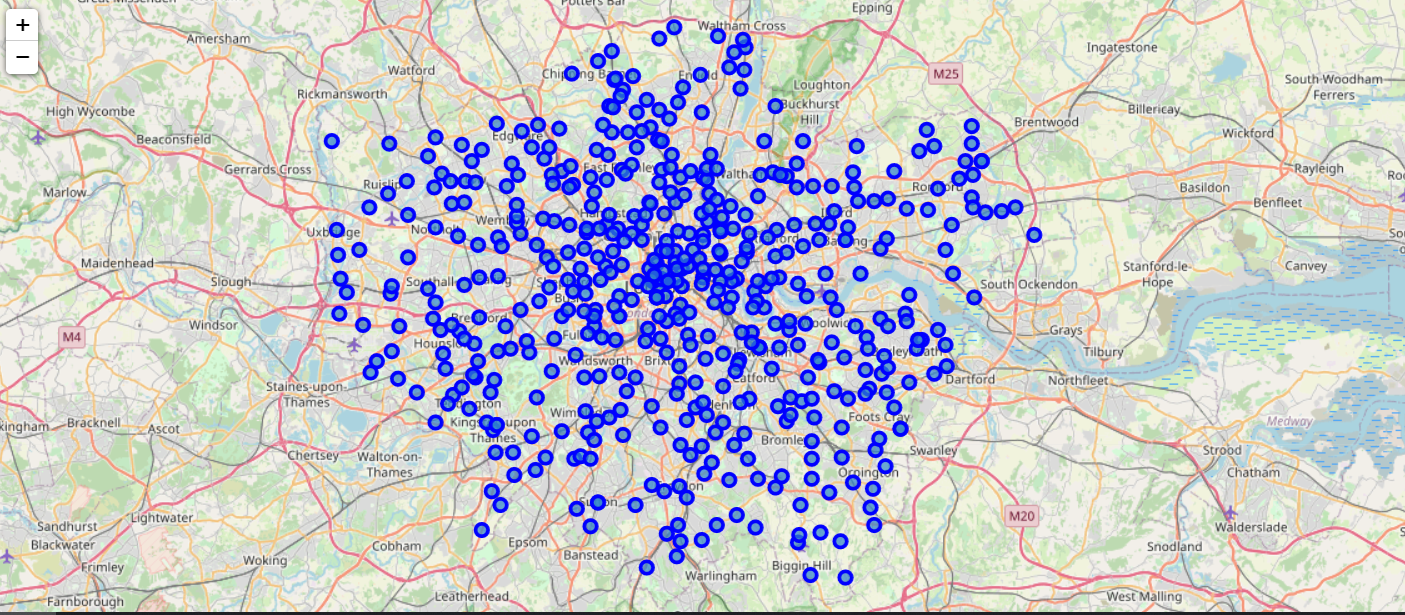

### 4.6.2. NYC Map
Use the same method to generate a map for New York City

In [24]:
map_nyc = folium.Map(location=[nyc_lat, nyc_lng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_nyc['Latitude'], df_nyc['Longitude'], df_nyc['Borough'], df_nyc['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='Green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

If you are unable to see the map in Github, below is the screenshot of the map:

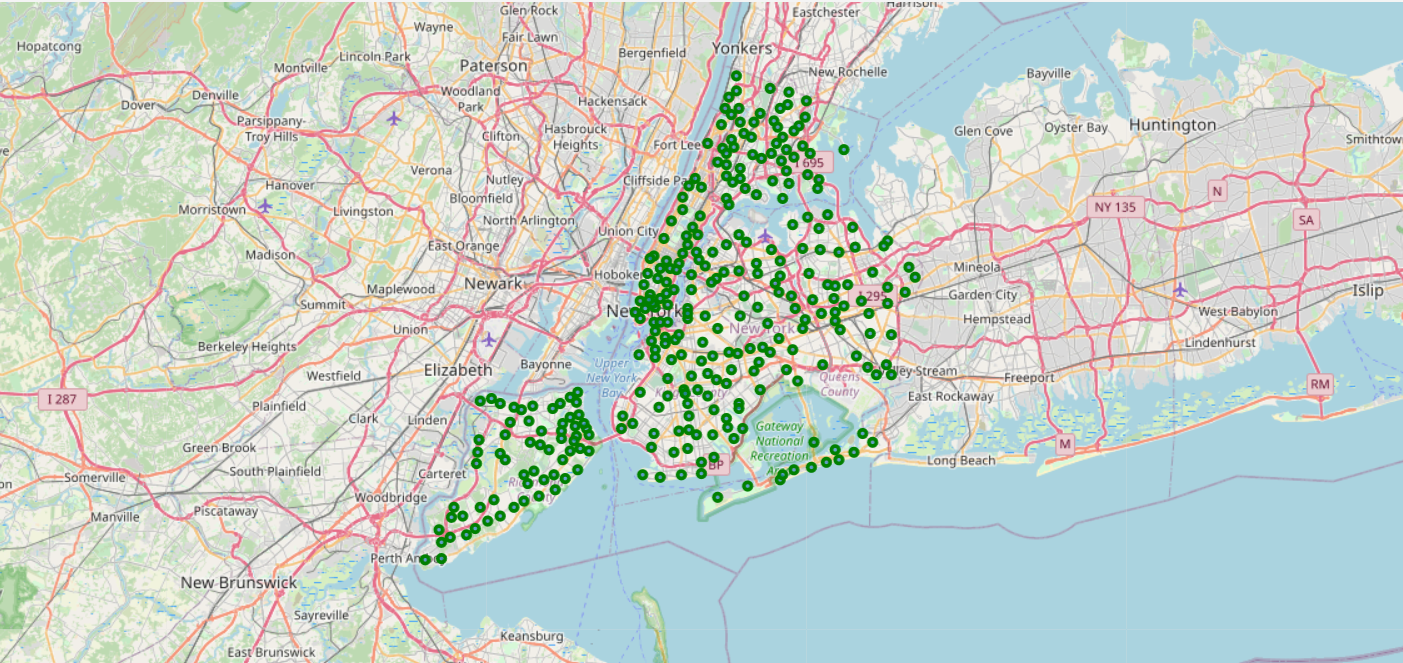

## 4.7. Venues
After collecting all data for neighborhood and generating the two maps, we need to utilize Foursquare API to obtain all venues near a specific neighborhood.

### 4.7.1. Credential Setup
To setup the API, we need credential information

In [53]:
CLIENT_ID = 'MFSULYGUEDVYY1WBAESH33FHXYJ13EUGOFIS343WRWVWCKEX' # your Foursquare ID
CLIENT_SECRET = 'ESSFIQBT4CFTEWLDIXUD5H3OU1SYWPC1MRILSMGI4M2GPHYH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MFSULYGUEDVYY1WBAESH33FHXYJ13EUGOFIS343WRWVWCKEX
CLIENT_SECRET:ESSFIQBT4CFTEWLDIXUD5H3OU1SYWPC1MRILSMGI4M2GPHYH


### 4.7.2. Function Declaration
To ease the process of getting nearby venues, we define such a function:

In [54]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### 4.7.3. London and NYC Venues
We call the function to get all London and NYC venues

In [55]:
london_venues = getNearbyVenues(names=df_lon['Neighborhood'],
                                   latitudes=df_lon['Latitude'],
                                   longitudes=df_lon['Longitude']
                                  )
london_venues.head()

Abbey Wood
Acton
Addington
Addiscombe
Albany Park
Aldgate
Aldwych
Alperton
Anerley
Angel
Aperfield
Archway
Ardleigh Green
Arkley
Arnos Grove
Balham
Bankside
Barbican
Barking
Barkingside
Barnehurst
Barnes
Barnes Cray
Barnet Gate
Barnsbury
Battersea
Bayswater
Beckenham
Beckton
Becontree
Becontree Heath
Beddington
Bedford Park
Belgravia
Bellingham
Belmont
Belmont
Belsize Park
Belvedere
Bermondsey
Berrylands
Bethnal Green
Bickley
Biggin Hill
Blackfen
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Blendon
Bloomsbury
Botany Bay
Bounds Green
Bow
Bowes Park
Brentford
Brent Cross
Brent Park
Brimsdown
Brixton
Brockley
Bromley
Bromley Common
Brompton
Brondesbury
Brunswick Park
Bulls Cross
Burnt Oak
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Canning Town
Canonbury
Carshalton
Castelnau
Castle Green
Catford
Chadwell Heath
Chalk Farm
Charing Cross
Charlton
Chase Cross
Cheam
Chelsea
Chelsfield
Chessington
Childs Hill
Chinatown
Chinbrook
Chingford
Chislehurst
Church 

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   Abbey Wood              51.485572                0.119687   
1   Abbey Wood              51.485572                0.119687   
2        Acton              51.506628               -0.244695   
3        Acton              51.506628               -0.244695   
4        Acton              51.506628               -0.244695   

                     Venue  Venue Latitude  Venue Longitude  \
0               Co-op Food       51.487650         0.113490   
1  Abbey Wood Caravan Club       51.485502         0.120014   
2          Sufi Restaurant       51.504070        -0.243703   
3        Princess Victoria       51.506530        -0.240915   
4               Cafe Paulo       51.506751        -0.248901   

              Venue Category  
0              Grocery Store  
1                 Campground  
2  Middle Eastern Restaurant  
3                  Gastropub  
4             Breakfast Spot

In [56]:
nyc_venues = getNearbyVenues(names=df_nyc['Neighborhood'],
                                   latitudes=df_nyc['Latitude'],
                                   longitudes=df_nyc['Longitude']
                                  )
nyc_venues.head()

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
3         Walgreens       40.896528       -73.844700        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

### 4.7.4. One Hot Encoding
The goal is to determine different type of venue (Venue Category) in the neighborhood of NYC and London. However, the attributes of venue category are categorical attributes. For the simplicity of model building and machine learning, we use One Hot Encoding to transform those categorical data to numeric data.

After performing One Hot Encoding, we will group them by neighborhood name and calculate the average of the frequency of each venue category for each neighborhood.

In [57]:
# one hot encoding for NYC
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

Yoga Studio  ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0            0    0                  0               0                  0   
1            0    0                  0               0                  0   
2            0    0                  0               0                  0   
3            0    0                  0               0                  0   
4            0    0                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                   0                 0                    0             0   
1                   0                 0                    0             0   
2                   0                 0                    0             0   
3                   0                 0                    0             0   
4                   0                 0                    0             0   

   Arcade  ...  Volleyball Court  Warehouse Store  Waste Facility  Waterfront  \
0       0  ...                 0                0               0           0   
1       0  ...                 0                0               0           0   
2       0  ...                 0                0               0           0   
3       0  ...                 0                0               0           0   
4       0  ...                 0                0               0           0   

   Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0                   0           0         0          0            0   
1                   0           0         0          0            0   
2                   0           0         0          0            0   
3                   0           0         0          0            0   
4                   0           0         0          0            0   

   Women's Store  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 430 columns]

In [59]:
# one hot encoding for London
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

Zoo Exhibit  Accessories Store  Acupuncturist  Adult Boutique  \
0            0                  0              0               0   
1            0                  0              0               0   
2            0                  0              0               0   
3            0                  0              0               0   
4            0                  0              0               0   

   Afghan Restaurant  African Restaurant  Airport  Airport Service  \
0                  0                   0        0                0   
1                  0                   0        0                0   
2                  0                   0        0                0   
3                  0                   0        0                0   
4                  0                   0        0                0   

   Airport Terminal  American Restaurant  ...  Waterfront  Whisky Bar  \
0                 0                    0  ...           0           0   
1                 0                    0  ...           0           0   
2                 0                    0  ...           0           0   
3                 0                    0  ...           0           0   
4                 0                    0  ...           0           0   

   Windmill  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0         0         0          0       0            0              0   
1         0         0          0       0            0              0   
2         0         0          0       0            0              0   
3         0         0          0       0            0              0   
4         0         0          0       0            0              0   

   Xinjiang Restaurant  Yoga Studio  
0                    0            0  
1                    0            0  
2                    0            0  
3                    0            0  
4                    0            0  

[5 rows x 414 columns]

Group the two tables by neighborhood and calculate the frequency of each category

In [61]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped

Neighborhood  Yoga Studio  ATM  Accessories Store  Adult Boutique  \
0         Allerton          0.0  0.0                0.0             0.0   
1         Annadale          0.0  0.0                0.0             0.0   
2    Arden Heights          0.0  0.0                0.0             0.0   
3        Arlington          0.0  0.0                0.0             0.0   
4         Arrochar          0.0  0.0                0.0             0.0   
..             ...          ...  ...                ...             ...   
296      Woodhaven          0.0  0.0                0.0             0.0   
297       Woodlawn          0.0  0.0                0.0             0.0   
298        Woodrow          0.0  0.0                0.0             0.0   
299       Woodside          0.0  0.0                0.0             0.0   
300      Yorkville          0.0  0.0                0.0             0.0   

     Afghan Restaurant  African Restaurant  Airport Terminal  \
0                  0.0                 0.0               0.0   
1                  0.0                 0.0               0.0   
2                  0.0                 0.0               0.0   
3                  0.0                 0.0               0.0   
4                  0.0                 0.0               0.0   
..                 ...                 ...               ...   
296                0.0                 0.0               0.0   
297                0.0                 0.0               0.0   
298                0.0                 0.0               0.0   
299                0.0                 0.0               0.0   
300                0.0                 0.0               0.0   

     American Restaurant  Antique Shop  ...  Volleyball Court  \
0               0.000000           0.0  ...               0.0   
1               0.083333           0.0  ...               0.0   
2               0.000000           0.0  ...               0.0   
3               0.000000           0.0  ...               0.0   
4               0.000000           0.0  ...               0.0   
..                   ...           ...  ...               ...   
296             0.000000           0.0  ...               0.0   
297             0.000000           0.0  ...               0.0   
298             0.000000           0.0  ...               0.0   
299             0.039474           0.0  ...               0.0   
300             0.000000           0.0  ...               0.0   

     Warehouse Store  Waste Facility  Waterfront  Weight Loss Center  \
0                0.0             0.0         0.0                 0.0   
1                0.0             0.0         0.0                 0.0   
2                0.0             0.0         0.0                 0.0   
3                0.0             0.0         0.0                 0.0   
4                0.0             0.0         0.0                 0.0   
..               ...             ...         ...                 ...   
296              0.0             0.0         0.0                 0.0   
297              0.0             0.0         0.0                 0.0   
298              0.0             0.0         0.0                 0.0   
299              0.0             0.0         0.0                 0.0   
300              0.0             0.0         0.0                 0.0   

     Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  
0           0.0      0.00   0.000000          0.0            0.0  
1           0.0      0.00   0.000000          0.0            0.0  
2           0.0      0.00   0.000000          0.0            0.0  
3           0.0      0.00   0.000000          0.0            0.0  
4           0.0      0.00   0.000000          0.0            0.0  
..          ...       ...        ...          ...            ...  
296         0.0      0.00   0.000000          0.0            0.0  
297         0.0      0.00   0.000000          0.0            0.0  
298         0.0      0.00   0.000000          0.0            0.0  
299         0.0     

In [62]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

Neighborhood  Zoo Exhibit  Accessories Store  Acupuncturist  \
0         Abbey Wood          0.0                0.0            0.0   
1              Acton          0.0                0.0            0.0   
2         Addiscombe          0.0                0.0            0.0   
3        Albany Park          0.0                0.0            0.0   
4            Aldgate          0.0                0.0            0.0   
..               ...          ...                ...            ...   
496    Woodside Park          0.0                0.0            0.0   
497         Woolwich          0.0                0.0            0.0   
498  Wormwood Scrubs          0.0                0.0            0.0   
499          Yeading          0.0                0.0            0.0   
500         Yiewsley          0.0                0.0            0.0   

     Adult Boutique  Afghan Restaurant  African Restaurant  Airport  \
0               0.0                0.0            0.000000      0.0   
1               0.0                0.0            0.000000      0.0   
2               0.0                0.0            0.000000      0.0   
3               0.0                0.0            0.000000      0.0   
4               0.0                0.0            0.000000      0.0   
..              ...                ...                 ...      ...   
496             0.0                0.0            0.000000      0.0   
497             0.0                0.0            0.020408      0.0   
498             0.0                0.0            0.000000      0.0   
499             0.0                0.0            0.000000      0.0   
500             0.0                0.0            0.000000      0.0   

     Airport Service  Airport Terminal  ...  Waterfront  Whisky Bar  Windmill  \
0                0.0               0.0  ...         0.0         0.0       0.0   
1                0.0               0.0  ...         0.0         0.0       0.0   
2                0.0               0.0  ...         0.0         0.0       0.0   
3                0.0               0.0  ...         0.0         0.0       0.0   
4                0.0               0.0  ...         0.0         0.0       0.0   
..               ...               ...  ...         ...         ...       ...   
496              0.0               0.0  ...         0.0         0.0       0.0   
497              0.0               0.0  ...         0.0         0.0       0.0   
498              0.0               0.0  ...         0.0         0.0       0.0   
499              0.0               0.0  ...         0.0         0.0       0.0   
500              0.0               0.0  ...         0.0         0.0       0.0   

     Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0        0.00   0.000000     0.0          0.0            0.0   
1        0.00   0.037037     0.0          0.0            0.0   
2        0.00   0.000000     0.0          0.0            0.0   
3        0.00   0.000000     0.0          0.0            0.0   
4        0.01   0.010000     0.0          0.0            0.0   
..        ...        ...     ...          ...            ...   
496      0.00   0.000000     0.0          0.0            0.0   
497      0.00   0.000000     0.0          0.0            0.0   
498      0.00   0.000000     0.0          0.0            0.0   
499      0.00   0.000000     0.0          0.0            0.0   
500      0.00   0.000000     0.0          0.0            0.0   

     Xinjiang Restaurant  Yoga Studio  
0                    0.0          0.0  
1                    0.0          0.0  
2                    0.0          0.0  
3                    0.0          0.0  
4                    0.0          0.0  
..                   ...          ...  
496                  0.0          0.0  
497                  0.0          0.0  
498                  0.0          0.0  
499                  0.0          0.0  
500                  0.0          0.0  

[501 rows x 414 columns]

## 4.8. Top Venues
The next process is to rank the top venue categories for each neighborhood for NYC and London

For simplicity, this function is created to return the most common venues:

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create two new data frames to save the most common venues for NYC and London

### 4.8.1. Top Venues: London

In [79]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
london_venues_sorted = pd.DataFrame(columns=columns)
london_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
   london_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

london_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0   Abbey Wood         Grocery Store            Campground   
1        Acton         Grocery Store                  Café   
2   Addiscombe                  Park         Grocery Store   
3  Albany Park                   Pub         Train Station   
4      Aldgate                 Hotel           Coffee Shop   

  3rd Most Common Venue        4th Most Common Venue 5th Most Common Venue  \
0            Food Truck  Eastern European Restaurant     Electronics Store   
1        Breakfast Spot                       Bakery     Fish & Chips Shop   
2                Bakery         Fast Food Restaurant    Chinese Restaurant   
3         Grocery Store            Indian Restaurant        Adult Boutique   
4          Cocktail Bar                         Café           Pizza Place   

  6th Most Common Venue      7th Most Common Venue      8th Most Common Venue  \
0    English Restaurant                Escape Room       Ethiopian Restaurant   
1             Gastropub                Coffee Shop  Middle Eastern Restaurant   
2                  Café             Cosmetics Shop                        Pub   
3        Farmers Market          Electronics Store         English Restaurant   
4  Gym / Fitness Center  Middle Eastern Restaurant                 Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0         Event Service            Event Space  
1  Fast Food Restaurant    Japanese Restaurant  
2     Fish & Chips Shop          Event Service  
3           Escape Room   Ethiopian Restaurant  
4                   Pub      Indian Restaurant

### 4.8.2. Top Venues: NYC

In [72]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nyc_venues_sorted = pd.DataFrame(columns=columns)
nyc_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
   nyc_venues_sorted.iloc[ind, 1:] = return_most_common_venues( nyc_grouped.iloc[ind, :], num_top_venues)

nyc_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place           Supermarket   
1       Annadale           Pizza Place   American Restaurant   
2  Arden Heights           Pizza Place              Pharmacy   
3      Arlington          Intersection         Deli / Bodega   
4       Arrochar              Bus Stop           Pizza Place   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                   Spa         Deli / Bodega    Chinese Restaurant   
1                Bakery          Liquor Store         Train Station   
2         Deli / Bodega              Bus Stop           Coffee Shop   
3              Bus Stop         Boat or Ferry           Coffee Shop   
4    Italian Restaurant         Deli / Bodega            Food Truck   

       6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0                Bus Station   Fast Food Restaurant                Bakery   
1           Sushi Restaurant                  Diner            Restaurant   
2              Women's Store          Event Service           Event Space   
3              Women's Store    Filipino Restaurant           Event Space   
4  Middle Eastern Restaurant  Outdoors & Recreation          Liquor Store   

  9th Most Common Venue 10th Most Common Venue  
0         Grocery Store  Check Cashing Service  
1        Cosmetics Shop          Deli / Bodega  
2               Exhibit             Eye Doctor  
3               Exhibit             Eye Doctor  
4            Bagel Shop         Sandwich Place

## 4.9. Modeling: KMeans Clustering
Use KMeans Clustering algorithm to cluster neighborhoods that share similar features. We cluster neighborhoods into 5 clusters.

### 4.9.1. Modeling: NYC

In [69]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_nyc = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_nyc.labels_[0:10] 

array([2, 2, 0, 0, 0, 3, 3, 2, 3, 2], dtype=int32)

Create a new dataframe, including all NYC neighborhoods, their top 10 venues, and the cluster labels

In [73]:
# add clustering labels
nyc_venues_sorted.insert(0, 'Cluster Labels', kmeans_nyc.labels_)

nyc_merged = df_nyc

nyc_merged = nyc_merged.join(nyc_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head()

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             2.0   
1   Bronx   Co-op City  40.874294 -73.829939             2.0   
2   Bronx  Eastchester  40.887556 -73.827806             0.0   
3   Bronx    Fieldston  40.895437 -73.905643             3.0   
4   Bronx    Riverdale  40.890834 -73.912585             3.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy         Deli / Bodega        Sandwich Place   
1           Bus Station  Fast Food Restaurant   Fried Chicken Joint   
2  Caribbean Restaurant         Deli / Bodega              Bus Stop   
3                 Plaza  Medical Supply Store           Bus Station   
4           Bus Station                  Park        Baseball Field   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0            Donut Shop          Dessert Shop        Ice Cream Shop   
1            Restaurant         Grocery Store                  Park   
2                 Diner     Convenience Store           Pizza Place   
3                 River   Filipino Restaurant         Event Service   
4         Moving Target  Medical Supply Store                  Bank   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Laundromat                  Food            Food Truck   
1              Pharmacy            Bagel Shop          Liquor Store   
2              Platform    Seafood Restaurant         Bowling Alley   
3           Event Space               Exhibit            Eye Doctor   
4                   Gym            Playground                 Plaza   

  10th Most Common Venue  
0          Event Service  
1            Pizza Place  
2   Fast Food Restaurant  
3                Factory  
4           Home Service

### 4.9.2. Modeling: London
Run the same algorithm for London

In [74]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_london = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_london.labels_[0:10] 

array([1, 1, 1, 1, 4, 4, 4, 1, 4, 1], dtype=int32)

In [80]:
# add clustering labels
london_venues_sorted.insert(0, 'Cluster Labels', kmeans_london.labels_)

london_merged = df_lon

london_merged = london_merged.join(london_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

london_merged.head(10)

Borough Neighborhood Latitude  Longitude  \
0               Bexley, Greenwich    Abbey Wood  51.4856   0.119687   
1   Ealing, Hammersmith and Fulham        Acton  51.5066  -0.244695   
2                          Croydon    Addington  44.4206   -76.9782   
3                          Croydon   Addiscombe  51.3797 -0.0742821   
4                           Bexley  Albany Park  51.4354   0.125965   
6                             City      Aldgate  51.5142 -0.0757186   
7                      Westminster      Aldwych  51.5122  -0.118896   
8                            Brent     Alperton  51.5408  -0.300096   
9                          Bromley      Anerley  51.4076 -0.0619394   
10                       Islington        Angel  51.5318  -0.105714   

    Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0              1.0         Grocery Store            Campground   
1              1.0         Grocery Store                  Café   
2              NaN                   NaN                   NaN   
3              1.0                  Park         Grocery Store   
4              1.0                   Pub         Train Station   
6              4.0                 Hotel           Coffee Shop   
7              4.0                   Pub               Theater   
8              4.0           Supermarket         Train Station   
9              1.0         Grocery Store                  Park   
10             4.0                   Pub           Coffee Shop   

   3rd Most Common Venue        4th Most Common Venue 5th Most Common Venue  \
0             Food Truck  Eastern European Restaurant     Electronics Store   
1         Breakfast Spot                       Bakery     Fish & Chips Shop   
2                    NaN                          NaN                   NaN   
3                 Bakery         Fast Food Restaurant    Chinese Restaurant   
4          Grocery Store            Indian Restaurant        Adult Boutique   
6           Cocktail Bar                         Café           Pizza Place   
7            Coffee Shop                 Burger Joint            Restaurant   
8         Sandwich Place             Asian Restaurant         Metro Station   
9   Fast Food Restaurant                  Supermarket     Convenience Store   
10                  Café                   Restaurant   Arts & Crafts Store   

   6th Most Common Venue      7th Most Common Venue  \
0     English Restaurant                Escape Room   
1              Gastropub                Coffee Shop   
2                    NaN                        NaN   
3                   Café             Cosmetics Shop   
4         Farmers Market          Electronics Store   
6   Gym / Fitness Center  Middle Eastern Restaurant   
7         Sandwich Place               Cocktail Bar   
8               Bus Stop                       Café   
9         Cricket Ground           Cuban Restaurant   
10  Gym / Fitness Center          Indian Restaurant   

        8th Most Common Venue     9th Most Common Venue 10th Most Common Venue  
0        Ethiopian Restaurant             Event Service            Event Space  
1   Middle Eastern Restaurant      Fast Food Restaurant    Japanese Restaurant  
2                         NaN                       NaN                    NaN  
3                         Pub         Fish & Chips Shop          Event Service  
4          English Restaurant               Escape Room   Ethiopian Restaurant  
6                  Restaurant                       Pub      Indian Restaurant  
7                       Hotel                       Bar           Dessert Shop  
8        Gym / Fitness Center         Indian Restaurant   Ethiopian Restaurant  
9           Electronics Store        English Restaurant            Escape Room  
10                 Food Truck  Mediterranean Restaurant          Burrito Place

### 4.9.3. Drop all empty values

In [83]:
print(london_merged.shape)
london_merged.dropna(axis=0,inplace=True)
print(london_merged.shape)
london_merged.head(10)

(515, 15)
(507, 15)


Borough Neighborhood Latitude  Longitude  \
0               Bexley, Greenwich    Abbey Wood  51.4856   0.119687   
1   Ealing, Hammersmith and Fulham        Acton  51.5066  -0.244695   
3                          Croydon   Addiscombe  51.3797 -0.0742821   
4                           Bexley  Albany Park  51.4354   0.125965   
6                             City      Aldgate  51.5142 -0.0757186   
7                      Westminster      Aldwych  51.5122  -0.118896   
8                            Brent     Alperton  51.5408  -0.300096   
9                          Bromley      Anerley  51.4076 -0.0619394   
10                       Islington        Angel  51.5318  -0.105714   
11                         Bromley    Aperfield  51.3102  0.0427001   

    Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0              1.0         Grocery Store            Campground   
1              1.0         Grocery Store                  Café   
3              1.0                  Park         Grocery Store   
4              1.0                   Pub         Train Station   
6              4.0                 Hotel           Coffee Shop   
7              4.0                   Pub               Theater   
8              4.0           Supermarket         Train Station   
9              1.0         Grocery Store                  Park   
10             4.0                   Pub           Coffee Shop   
11             1.0         Grocery Store          Home Service   

   3rd Most Common Venue        4th Most Common Venue 5th Most Common Venue  \
0             Food Truck  Eastern European Restaurant     Electronics Store   
1         Breakfast Spot                       Bakery     Fish & Chips Shop   
3                 Bakery         Fast Food Restaurant    Chinese Restaurant   
4          Grocery Store            Indian Restaurant        Adult Boutique   
6           Cocktail Bar                         Café           Pizza Place   
7            Coffee Shop                 Burger Joint            Restaurant   
8         Sandwich Place             Asian Restaurant         Metro Station   
9   Fast Food Restaurant                  Supermarket     Convenience Store   
10                  Café                   Restaurant   Arts & Crafts Store   
11           Coffee Shop                  Supermarket    Falafel Restaurant   

   6th Most Common Venue        7th Most Common Venue  \
0     English Restaurant                  Escape Room   
1              Gastropub                  Coffee Shop   
3                   Café               Cosmetics Shop   
4         Farmers Market            Electronics Store   
6   Gym / Fitness Center    Middle Eastern Restaurant   
7         Sandwich Place                 Cocktail Bar   
8               Bus Stop                         Café   
9         Cricket Ground             Cuban Restaurant   
10  Gym / Fitness Center            Indian Restaurant   
11        Duty-free Shop  Eastern European Restaurant   

        8th Most Common Venue     9th Most Common Venue 10th Most Common Venue  
0        Ethiopian Restaurant             Event Service            Event Space  
1   Middle Eastern Restaurant      Fast Food Restaurant    Japanese Restaurant  
3                         Pub         Fish & Chips Shop          Event Service  
4          English Restaurant               Escape Room   Ethiopian Restaurant  
6                  Restaurant                       Pub      Indian Restaurant  
7                       Hotel                       Bar           Dessert Shop  
8        Gym / Fitness Center         Indian Restaurant   Ethiopian Restaurant  
9           Electronics Store        English Restaurant            Escape Room  
10                 Food Truck  Mediterranean Restaurant          Burrito Place  
11          Electronics Store        English Restaurant            Escape Room

In [84]:
print(nyc_merged.shape)
nyc_merged.dropna(axis=0,inplace=True)
print(nyc_merged.shape)
nyc_merged.head(10)

(306, 15)
(305, 15)


Borough    Neighborhood   Latitude  Longitude  Cluster Labels  \
0      Bronx       Wakefield  40.894705 -73.847201             2.0   
1      Bronx      Co-op City  40.874294 -73.829939             2.0   
2      Bronx     Eastchester  40.887556 -73.827806             0.0   
3      Bronx       Fieldston  40.895437 -73.905643             3.0   
4      Bronx       Riverdale  40.890834 -73.912585             3.0   
5      Bronx     Kingsbridge  40.881687 -73.902818             2.0   
6  Manhattan     Marble Hill  40.876551 -73.910660             2.0   
7      Bronx        Woodlawn  40.898273 -73.867315             0.0   
8      Bronx         Norwood  40.877224 -73.879391             2.0   
9      Bronx  Williamsbridge  40.881039 -73.857446             3.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy         Deli / Bodega        Sandwich Place   
1           Bus Station  Fast Food Restaurant   Fried Chicken Joint   
2  Caribbean Restaurant         Deli / Bodega              Bus Stop   
3                 Plaza  Medical Supply Store           Bus Station   
4           Bus Station                  Park        Baseball Field   
5           Pizza Place                   Bar        Sandwich Place   
6           Coffee Shop                   Gym        Discount Store   
7         Deli / Bodega                   Pub     Food & Drink Shop   
8           Pizza Place                  Park                  Bank   
9  Caribbean Restaurant            Soup Place                   Bar   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0            Donut Shop          Dessert Shop        Ice Cream Shop   
1            Restaurant         Grocery Store                  Park   
2                 Diner     Convenience Store           Pizza Place   
3                 River   Filipino Restaurant         Event Service   
4         Moving Target  Medical Supply Store                  Bank   
5    Mexican Restaurant                Bakery   Fried Chicken Joint   
6        Sandwich Place           Yoga Studio      Video Game Store   
7           Pizza Place            Playground            Food Truck   
8              Pharmacy         Deli / Bodega  Fast Food Restaurant   
9             Nightclub            Food Stand            Food Court   

       7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                 Laundromat                  Food            Food Truck   
1                   Pharmacy            Bagel Shop          Liquor Store   
2                   Platform    Seafood Restaurant         Bowling Alley   
3                Event Space               Exhibit            Eye Doctor   
4                        Gym            Playground                 Plaza   
5  Latin American Restaurant            Donut Shop                  Café   
6            Supplement Shop              Pharmacy            Donut Shop   
7                       Park         Grocery Store              Pharmacy   
8                 Restaurant    Mexican Restaurant           Coffee Shop   
9       Ethiopian Restaurant         Event Service           Event Space   

  10th Most Common Venue  
0          Event Service  
1            Pizza Place  
2   Fast Food Restaurant  
3                Factory  
4           Home Service  
5            Supermarket  
6                  Diner  
7           Liquor Store  
8         Sandwich Place  
9                Exhibit

# 5. Results
After the model is built, gather all the results by ploting all neighborhoods with clustered result to help visualization

Similar to what we have plotted above, we use Folium to plot the map

## 5.1. Map Result: NYC

In [86]:
map2_nyc = folium.Map(location=[nyc_lat, nyc_lng], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster+1)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map2_nyc)
       
map2_nyc

If you are unable to see the map in GitHub, below is a screenshot

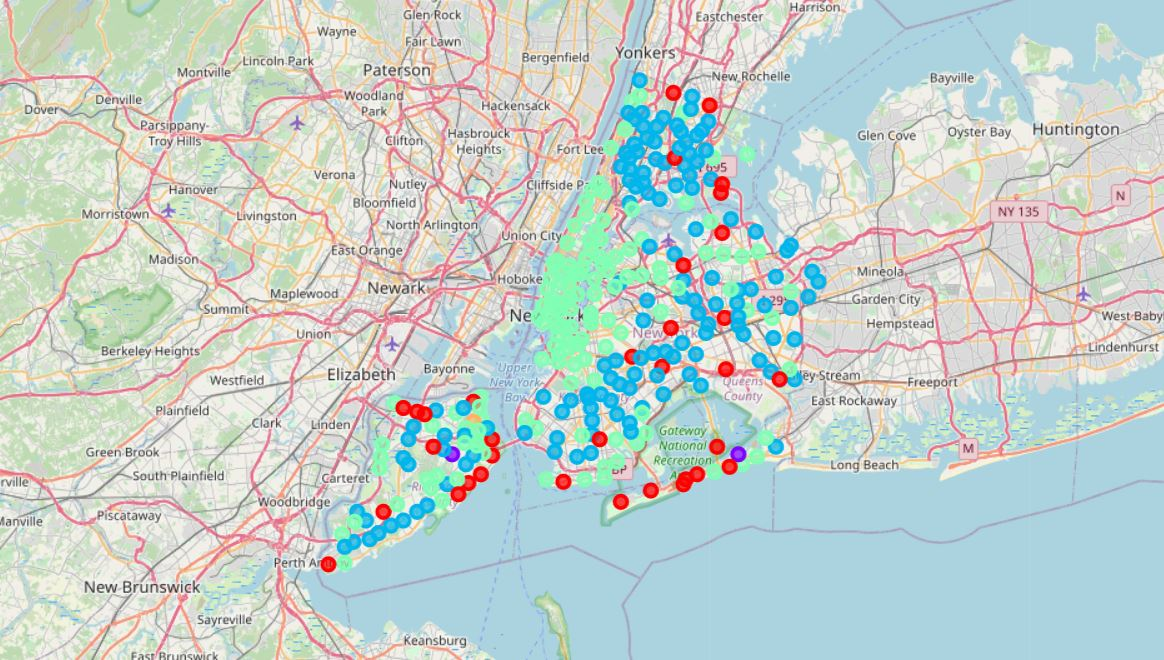

## 5.2. Map Result: London

In [88]:
map2_london = folium.Map(location=[london_lat, london_lng], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster+1)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map2_london)
       
map2_london

If you are unable to see the map on GitHub, below is a screenshot

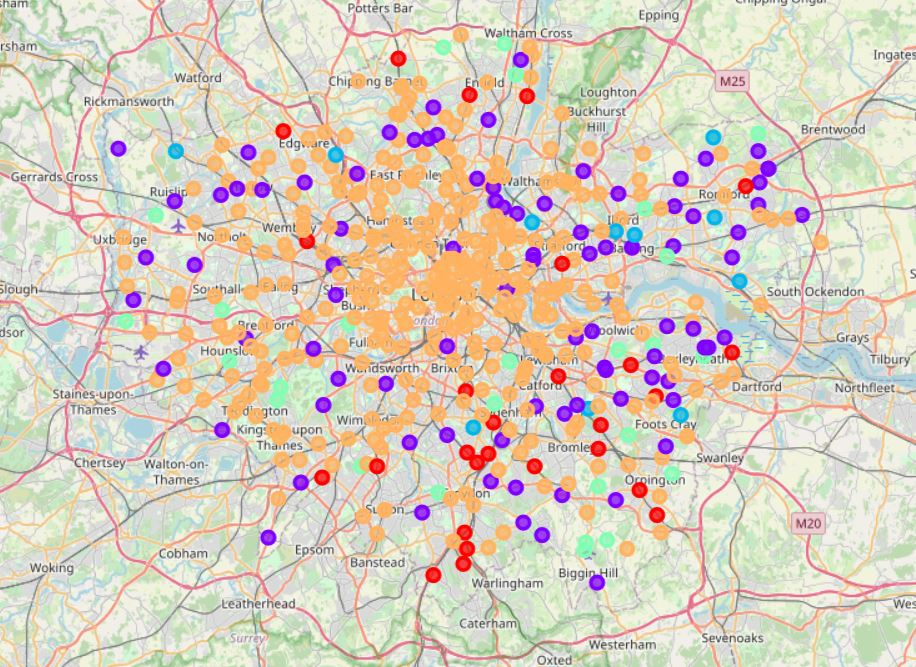

## 5.3. Examine Clusters
We print a data frame for each different cluster for NYC and London.

### 5.3.1. NYC
Cluster 1:

In [89]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood 1st Most Common Venue         2nd Most Common Venue  \
2         Eastchester  Caribbean Restaurant                 Deli / Bodega   
7            Woodlawn         Deli / Bodega                           Pub   
28        Throgs Neck         Deli / Bodega                           Bar   
32           Van Nest           Pizza Place                 Deli / Bodega   
39     Edgewater Park    Italian Restaurant                 Deli / Bodega   
72      East New York         Deli / Bodega                   Pizza Place   
78       Coney Island      Baseball Stadium  Theme Park Ride / Attraction   
89         Ocean Hill         Deli / Bodega                          Food   
144          Glendale           Pizza Place                       Brewery   
148  South Ozone Park                  Park                 Deli / Bodega   
150        Whitestone       Bubble Tea Shop                  Dance Studio   
159         Briarwood         Deli / Bodega                    Playground   
171     Broad Channel           Pizza Place                      Dive Bar   
172      Breezy Point                 Beach                         Trail   
179          Neponsit                 Beach                 Women's Store   
190      Belle Harbor                 Beach                           Pub   
191     Rockaway Park                 Beach                    Donut Shop   
193        Brookville         Deli / Bodega                 Women's Store   
195      North Corona         Deli / Bodega                        Bakery   
198      New Brighton              Bus Stop                 Deli / Bodega   
204       South Beach                  Pier                           ATM   
206  Mariner's Harbor    Italian Restaurant                 Deli / Bodega   
217       Tottenville    Mexican Restaurant            Italian Restaurant   
227         Arlington          Intersection                 Deli / Bodega   
228          Arrochar              Bus Stop                   Pizza Place   
232     Midland Beach                 Beach            Russian Restaurant   
234    New Dorp Beach    Italian Restaurant                 Deli / Bodega   
241     Arden Heights           Pizza Place                      Pharmacy   
252       Shore Acres    Italian Restaurant                      Bus Stop   
258          Elm Park              Bus Stop                 Deli / Bodega   
285       Willowbrook              Bus Stop            Chinese Restaurant   
288           Roxbury             Irish Pub                         Beach   
296           Madison            Bagel Shop                 Deli / Bodega   
302           Hammels                 Beach           Fried Chicken Joint   

         3rd Most Common Venue     4th Most Common Venue  \
2                     Bus Stop                     Diner   
7            Food & Drink Shop               Pizza Place   
28                   Juice Bar          Asian Restaurant   
32   Middle Eastern Restaurant                Donut Shop   
39                 Pizza Place                Donut Shop   
72                       Plaza                Food Truck   
78                       Beach                  Pharmacy   
89         Fried Chicken Joint                  Bus Stop   
144              Deli / Bodega         Food & Drink Shop   
148                        Bar                Food Truck   
150              Deli / Bodega               Candy Store   
159        Arts & Crafts Store         Indian Restaurant   
171            Other Nightlife             Deli / Bodega   
172                   Bus Stop       Monument / Landmark   
179        Filipino Restaurant             Event Service   
190                        Spa                  Boutique   
191                Pizza Place  Mediterranean Restaurant   
193        Filipino Restaurant      Ethiopian Restaurant   
195       Gym / Fitness Center               Pizza Place   
198               Home Service                      Park   
204                      Beach             Deli / Bod

Cluster 2

In [90]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
192   Somerville                  Park         Women's Store   
203    Todt Hill                  Park         Women's Store   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
192  Entertainment Service         Event Service           Event Space   
203  Entertainment Service         Event Service           Event Space   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
192               Exhibit            Eye Doctor               Factory   
203               Exhibit            Eye Doctor               Factory   

    9th Most Common Venue 10th Most Common Venue  
192    Falafel Restaurant                   Farm  
203    Falafel Restaurant                   Farm

Cluster 3

In [91]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood  1st Most Common Venue      2nd Most Common Venue  \
0              Wakefield               Pharmacy              Deli / Bodega   
1             Co-op City            Bus Station       Fast Food Restaurant   
5            Kingsbridge            Pizza Place                        Bar   
6            Marble Hill            Coffee Shop                        Gym   
8                Norwood            Pizza Place                       Park   
..                   ...                    ...                        ...   
295        Highland Park          Grocery Store  Latin American Restaurant   
297            Bronxdale  Performing Arts Venue             Breakfast Spot   
298             Allerton            Pizza Place                Supermarket   
299  Kingsbridge Heights            Pizza Place         Chinese Restaurant   
300              Erasmus   Caribbean Restaurant                   Pharmacy   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0          Sandwich Place            Donut Shop          Dessert Shop   
1     Fried Chicken Joint            Restaurant         Grocery Store   
5          Sandwich Place    Mexican Restaurant                Bakery   
6          Discount Store        Sandwich Place           Yoga Studio   
8                    Bank              Pharmacy         Deli / Bodega   
..                    ...                   ...                   ...   
295                Garden          Tennis Court         Metro Station   
297    Mexican Restaurant    Chinese Restaurant           Pizza Place   
298                   Spa         Deli / Bodega    Chinese Restaurant   
299    Spanish Restaurant           Bus Station         Grocery Store   
300           Yoga Studio     Health Food Store     Convenience Store   

           6th Most Common Venue      7th Most Common Venue  \
0                 Ice Cream Shop                 Laundromat   
1                           Park                   Pharmacy   
5            Fried Chicken Joint  Latin American Restaurant   
6               Video Game Store            Supplement Shop   
8           Fast Food Restaurant                 Restaurant   
..                           ...                        ...   
295                         Park               Liquor Store   
297  Eastern European Restaurant                Supermarket   
298                  Bus Station       Fast Food Restaurant   
299                  Coffee Shop                       Food   
300                   Playground                Pizza Place   

    8th Most Common Venue 9th Most Common Venue  10th Most Common Venue  
0                    Food            Food Truck           Event Service  
1              Bagel Shop          Liquor Store             Pizza Place  
5              Donut Shop                  Café             Supermarket  
6                Pharmacy            Donut Shop                   Diner  
8      Mexican Restaurant           Coffee Shop          Sandwich Place  
..                    ...                   ...                     ...  
295           Pizza Place  Gym / Fitness Center  Furniture / Home Store  
297                  Bank    Spanish Restaurant                     Gym  
298                Bakery         Grocery Store   Check Cashing Service  
299            Shoe Store                  Park      Mexican Restaurant  
300            Donut Shop              Bus Line              Food Truck  

[135 rows x 11 columns]

Cluster 4

In [92]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood 1st Most Common Venue   2nd Most Common Venue  \
3         Fieldston                 Plaza    Medical Supply Store   
4         Riverdale           Bus Station                    Park   
9    Williamsbridge  Caribbean Restaurant              Soup Place   
12      City Island         Deli / Bodega      Seafood Restaurant   
22      Port Morris        Baseball Field  Furniture / Home Store   
..              ...                   ...                     ...   
294           Malba             Rest Area                Bus Line   
301    Hudson Yards  Gym / Fitness Center      Italian Restaurant   
303       Bayswater            Playground           Women's Store   
304    Queensbridge                 Hotel               Hotel Bar   
305       Fox Hills          Cocktail Bar                Bus Stop   

      3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
3               Bus Station                  River   Filipino Restaurant   
4            Baseball Field          Moving Target  Medical Supply Store   
9                       Bar              Nightclub            Food Stand   
12   Thrift / Vintage Store        Harbor / Marina   Arts & Crafts Store   
22      Peruvian Restaurant          Metro Station            Donut Shop   
..                      ...                    ...                   ...   
294            Tennis Court          Women's Store                 Field   
301     American Restaurant                   Café                 Hotel   
303                   Field   Ethiopian Restaurant         Event Service   
304      Athletics & Sports  Performing Arts Venue              Platform   
305     American Restaurant              BBQ Joint        Sandwich Place   

    6th Most Common Venue 7th Most Common Venue      8th Most Common Venue  \
3           Event Service           Event Space                    Exhibit   
4                    Bank                   Gym                 Playground   
9              Food Court  Ethiopian Restaurant              Event Service   
12          Grocery Store                  Park              Boat or Ferry   
22             Distillery            Restaurant  Latin American Restaurant   
..                    ...                   ...                        ...   
294  Ethiopian Restaurant         Event Service                Event Space   
301            Restaurant           Coffee Shop                        Gym   
303           Event Space               Exhibit                 Eye Doctor   
304        Sandwich Place          Cocktail Bar                  Roof Deck   
305            Playground         Women's Store       Fast Food Restaurant   

    9th Most Common Venue 10th Most Common Venue  
3              Eye Doctor                Factory  
4                   Plaza           Home Service  
9             Event Space                Exhibit  
12         Baseball Field                    Bar  
22                Brewery       Storage Facility  
..                    ...                    ...  
294               Exhibit             Eye Doctor  
301               Dog Run                   Park  
303               Factory     Falafel Restaurant  
304  Gym / Fitness Center         Scenic Lookout  
305         Event Service            Event Space  

[133 rows x 11 columns]

Cluster 5

In [96]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
202  Grymes Hill               Dog Run         Women's Store   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
202                 Field  Ethiopian Restaurant         Event Service   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
202           Event Space               Exhibit            Eye Doctor   

    9th Most Common Venue 10th Most Common Venue  
202               Factory     Falafel Restaurant

### 5.3.2. London

Cluster 1

In [97]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

Neighborhood       1st Most Common Venue 2nd Most Common Venue  \
46          Bickley              Cosmetics Shop        Cricket Ground   
92       Chelsfield               Train Station           Pizza Place   
113        Coulsdon                        Park             Pool Hall   
127  Crystal Palace                    Platform     Outdoor Sculpture   
152       Eden Park          English Restaurant                 Hotel   
159        Elmstead                    Platform         Train Station   
167      Falconwood          English Restaurant                 Trail   
186      Gidea Park               Grocery Store                   Bar   
193     Grange Park           Indian Restaurant           Golf Course   
203     Hadley Wood           Convenience Store         Train Station   
240    Hither Green                    Platform                  Café   
258          Kenley               Grocery Store        Cricket Ground   
275        Lamorbey                    Platform         Grocery Store   
346    Old Coulsdon        Gym / Fitness Center     Convenience Store   
348      Old Malden  Construction & Landscaping                  Food   
350       Orpington                    Platform                   Pub   
369     Ponders End              Breakfast Spot    English Restaurant   
384     Riddlesdown               Train Station           Yoga Studio   
393        Selhurst                    Platform         Grocery Store   
406     Slade Green  Construction & Landscaping         Train Station   
415   South Norwood                    Platform                  Café   
426       St Helier               Train Station    English Restaurant   
437        Stanmore                    Platform                  Park   
441     Stonebridge  Construction & Landscaping         Train Station   
458  Thornton Heath                    Platform                 Plaza   
469      Tulse Hill                    Platform           Coffee Shop   
502        West Ham                    Platform     Fish & Chips Shop   

        3rd Most Common Venue        4th Most Common Venue  \
46              Train Station                 Home Service   
92       Fast Food Restaurant                     Pharmacy   
113           Thai Restaurant                     Platform   
127                      Farm             Sculpture Garden   
152               Sports Club                Train Station   
159               Yoga Studio           Falafel Restaurant   
167             Train Station                     Platform   
186             Train Station                     Platform   
193             Train Station           English Restaurant   
203                      Farm  Eastern European Restaurant   
240             Grocery Store            Fish & Chips Shop   
258             Train Station                     Platform   
275                       Bar                Train Station   
346               Auto Garage                Train Station   
348             Train Station           Falafel Restaurant   
350             Train Station                  Coffee Shop   
369             Train Station                Boat or Ferry   
384       Dumpling Restaurant  Eastern European Restaurant   
393      Fast Food Restaurant                         Café   
406                  Platform                         Café   
415                       Pub                  Supermarket   
426                     Hotel                         Café   
437        Italian Restaurant                  Pizza Place   
441                     Diner                     Platform   
458  Mediterranean Restaurant                  Coffee Shop   
469                       Pub           Italian Restaurant   
502         Convenience Store                          Gym   

           5th Most Common Venue        6th Most Common Venue  \
46                          Farm  Eastern European Restaurant   
92                   Yoga Studio                  Fabric Shop   
113                  Fabric Sh

Cluster 2

In [98]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

Neighborhood 1st Most Common Venue       2nd Most Common Venue  \
0       Abbey Wood         Grocery Store                  Campground   
1            Acton         Grocery Store                        Café   
3       Addiscombe                  Park               Grocery Store   
4      Albany Park                   Pub               Train Station   
9          Anerley         Grocery Store                        Park   
..             ...                   ...                         ...   
498   West Drayton                   Pub                       Hotel   
500     West Green         Grocery Store          Turkish Restaurant   
504    West Harrow     Indian Restaurant             Warehouse Store   
525  Woodside Park                  Café               Grocery Store   
529        Yeading         Grocery Store  Construction & Landscaping   

    3rd Most Common Venue        4th Most Common Venue  \
0              Food Truck  Eastern European Restaurant   
1          Breakfast Spot                       Bakery   
3                  Bakery         Fast Food Restaurant   
4           Grocery Store            Indian Restaurant   
9    Fast Food Restaurant                  Supermarket   
..                    ...                          ...   
498       Bed & Breakfast                Grocery Store   
500        Breakfast Spot                     Bus Stop   
504         Grocery Store                Metro Station   
525          Soccer Field           Falafel Restaurant   
529    Chinese Restaurant                     Pharmacy   

           5th Most Common Venue 6th Most Common Venue  \
0              Electronics Store    English Restaurant   
1              Fish & Chips Shop             Gastropub   
3             Chinese Restaurant                  Café   
4                 Adult Boutique        Farmers Market   
9              Convenience Store        Cricket Ground   
..                           ...                   ...   
498            Indian Restaurant       Coworking Space   
500                         Park                Lounge   
504                         Park           Fabric Shop   
525  Eastern European Restaurant     Electronics Store   
529                  Fabric Shop        Duty-free Shop   

           7th Most Common Venue        8th Most Common Venue  \
0                    Escape Room         Ethiopian Restaurant   
1                    Coffee Shop    Middle Eastern Restaurant   
3                 Cosmetics Shop                          Pub   
4              Electronics Store           English Restaurant   
9               Cuban Restaurant            Electronics Store   
..                           ...                          ...   
498           Falafel Restaurant  Eastern European Restaurant   
500                   Steakhouse          Japanese Restaurant   
504               Duty-free Shop  Eastern European Restaurant   
525           English Restaurant                  Escape Room   
529  Eastern European Restaurant            Electronics Store   

    9th Most Common Venue 10th Most Common Venue  
0           Event Service            Event Space  
1    Fast Food Restaurant    Japanese Restaurant  
3       Fish & Chips Shop          Event Service  
4             Escape Room   Ethiopian Restaurant  
9      English Restaurant            Escape Room  
..                    ...                    ...  
498     Electronics Store     English Restaurant  
500           Coffee Shop                    Bar  
504     Electronics Store     English Restaurant  
525  Ethiopian Restaurant          Event Service  
529    English Restaurant            Escape Room  

[90 rows x 11 columns]

Cluster 3

In [99]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
96             Chinbrook                  Park          Dance Studio   
192         Grahame Park                  Park    Salon / Barbershop   
201      Hackney Marshes                  Park            Bike Trail   
229  Havering-atte-Bower                  Park                  Farm   
287        Little Ilford                  Park                  Farm   
294              Loxford                  Park                  Pool   
331           North Cray                  Park                  Farm   
332            North End                  Park                  Farm   
341            Northwood                  Park           Golf Course   
378              Rainham                  Park    Chinese Restaurant   
389           Rush Green                  Park                  Farm   
476        Upper Norwood                  Park    English Restaurant   

           3rd Most Common Venue        4th Most Common Venue  \
96                          Farm  Eastern European Restaurant   
192                   Hobby Shop                     Bus Stop   
201                         Farm  Eastern European Restaurant   
229  Eastern European Restaurant            Electronics Store   
287  Eastern European Restaurant            Electronics Store   
294                Event Service           Falafel Restaurant   
331  Eastern European Restaurant            Electronics Store   
332  Eastern European Restaurant            Electronics Store   
341                   Food Truck  Eastern European Restaurant   
378            Fish & Chips Shop           Falafel Restaurant   
389  Eastern European Restaurant            Electronics Store   
476                         Farm  Eastern European Restaurant   

           5th Most Common Venue        6th Most Common Venue  \
96             Electronics Store           English Restaurant   
192                  Fabric Shop               Duty-free Shop   
201            Electronics Store           English Restaurant   
229           English Restaurant                  Escape Room   
287           English Restaurant                  Escape Room   
294               Duty-free Shop  Eastern European Restaurant   
331           English Restaurant                  Escape Room   
332           English Restaurant                  Escape Room   
341            Electronics Store           English Restaurant   
378  Eastern European Restaurant            Electronics Store   
389           English Restaurant                  Escape Room   
476            Electronics Store                  Escape Room   

           7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
96                   Escape Room  Ethiopian Restaurant         Event Service   
192  Eastern European Restaurant     Electronics Store    English Restaurant   
201                  Escape Room  Ethiopian Restaurant         Event Service   
229         Ethiopian Restaurant         Event Service           Event Space   
287         Ethiopian Restaurant         Event Service           Event Space   
294            Electronics Store    English Restaurant           Escape Room   
331         Ethiopian Restaurant         Event Service           Event Space   
332         Ethiopian Restaurant         Event Service           Event Space   
341                  Escape Room  Ethiopian Restaurant         Event Service   
378           English Restaurant           Escape Room  Ethiopian Restaurant   
389         Ethiopian Restaurant         Event Service           Event Space   
476         Ethiopian Restaurant         Event Service           Event Space   

    10th Most Common Venue  
96             Event Space  
192            Escape Room  
201            Event Space  
229                Exhibit  
287                Exhibit  
294   Ethiopian Restaurant  
331                Exhibit  
332                Exhibit  
341            Event Space  
378          Event Service  
389                Exhi

Cluster 4

In [100]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

Neighborhood 1st Most Common Venue       2nd Most Common Venue  \
21        Barnehurst                   Pub            Asian Restaurant   
33        Beddington                   Pub                        Park   
47       Biggin Hill                   Pub                     Airport   
55        Botany Bay                   Pub                 Sports Club   
67    Bromley Common                   Pub                 Bus Station   
71       Bulls Cross                   Pub                Soccer Field   
82         Castelnau                   Pub           French Restaurant   
83      Castle Green                   Pub               Go Kart Track   
98       Chislehurst                   Pub                   Gastropub   
136      Derry Downs                   Pub          Photography Studio   
138            Downe                   Pub                Home Service   
150     East Wickham                   Pub                        Farm   
162  Enfield Highway                   Pub               Grocery Store   
207              Ham                   Pub                        Café   
219    Harmondsworth                   Pub             Bed & Breakfast   
250         Hounslow                   Pub                    Bus Stop   
253         Ickenham                   Pub          Chinese Restaurant   
279     Leaves Green                   Pub                     Stables   
293     Lower Morden                   Pub  Construction & Landscaping   
328        Noak Hill                   Pub                    Bus Stop   
342    Norwood Green                   Pub                  Playground   
344          Nunhead                   Pub                        Park   
362        Petersham                   Pub                  Playground   
395      Seven Kings                   Pub               Train Station   
401   Shooter's Hill                   Pub                      Forest   
453    Sydenham Hill                Forest                         Pub   

    3rd Most Common Venue        4th Most Common Venue  \
21            Pizza Place    Middle Eastern Restaurant   
33         Hardware Store            Indian Restaurant   
47        Airport Service               Massage Studio   
55                Daycare            Food & Drink Shop   
67            Gas Station         Fast Food Restaurant   
71                 Garden                         Park   
82                   Café                         Lake   
83               Bus Stop                   Skate Park   
98      Indian Restaurant                         Café   
136   Dumpling Restaurant  Eastern European Restaurant   
138                  Farm  Eastern European Restaurant   
150            Food Truck  Eastern European Restaurant   
162            Hookah Bar           Turkish Restaurant   
207           Supermarket                         Park   
219        Duty-free Shop            Electronics Store   
250           Men's Store            Electronics Store   
253                  Park                       Bakery   
279                  Farm  Eastern European Restaurant   
293         Garden Center                         Farm   
328           Yoga Studio                         Farm   
342                  Café           Falafel Restaurant   
344          Burger Joint           Falafel Restaurant   
362                  Café                  Bus Station   
395             Irish Pub                 Cupcake Shop   
401                  Café                         Farm   
453                  Park            Food & Drink Shop   

           5th Most Common Venue        6th Most Common Venue  \
21                          Farm            Electronics Store   
33                Adult Boutique               Farmers Market   
47                          Farm  Eastern European Restaurant   
55                    Food Court  Eastern European Restaurant   
67                          Food                  Flower Shop   
71                      Creperie               Crick

Cluster 5

In [101]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
6            Aldgate                 Hotel           Coffee Shop   
7            Aldwych                   Pub               Theater   
8           Alperton           Supermarket         Train Station   
10             Angel                   Pub           Coffee Shop   
12           Archway           Coffee Shop         Grocery Store   
..               ...                   ...                   ...   
523        Woodlands                  Café                   Pub   
524         Woodside          Tram Station     Indian Restaurant   
526         Woolwich                   Pub         Grocery Store   
528  Wormwood Scrubs                   Gym         Track Stadium   
530         Yiewsley              Platform                   Pub   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
6            Cocktail Bar                  Café           Pizza Place   
7             Coffee Shop          Burger Joint            Restaurant   
8          Sandwich Place      Asian Restaurant         Metro Station   
10                   Café            Restaurant   Arts & Crafts Store   
12                    Pub           Pizza Place                  Café   
..                    ...                   ...                   ...   
523  Fast Food Restaurant              Bus Stop            Restaurant   
524    Chinese Restaurant                  Park    Falafel Restaurant   
526  Fast Food Restaurant                 Plaza           Coffee Shop   
528        Baseball Field              Bus Stop                  Park   
530           Supermarket  Fast Food Restaurant         Grocery Store   

           6th Most Common Venue      7th Most Common Venue  \
6           Gym / Fitness Center  Middle Eastern Restaurant   
7                 Sandwich Place               Cocktail Bar   
8                       Bus Stop                       Café   
10          Gym / Fitness Center          Indian Restaurant   
12            Italian Restaurant        Japanese Restaurant   
..                           ...                        ...   
523                  Supermarket             Breakfast Spot   
524  Eastern European Restaurant          Electronics Store   
526               Clothing Store                     Bakery   
528                  Yoga Studio                Fabric Shop   
530           Chinese Restaurant            Bed & Breakfast   

           8th Most Common Venue     9th Most Common Venue  \
6                     Restaurant                       Pub   
7                          Hotel                       Bar   
8           Gym / Fitness Center         Indian Restaurant   
10                    Food Truck  Mediterranean Restaurant   
12          Gym / Fitness Center                 Gastropub   
..                           ...                       ...   
523                        River         Convenience Store   
524           English Restaurant               Escape Room   
526                     Pharmacy          Asian Restaurant   
528  Eastern European Restaurant         Electronics Store   
530               Discount Store                      Café   

    10th Most Common Venue  
6        Indian Restaurant  
7             Dessert Shop  
8     Ethiopian Restaurant  
10           Burrito Place  
12        Asian Restaurant  
..                     ...  
523       Czech Restaurant  
524   Ethiopian Restaurant  
526            Supermarket  
528     English Restaurant  
530            Coffee Shop  

[352 rows x 11 columns]

# 6. Discussion
It can be seen that London has a wide variety of neighborhoods.Each cluster has more than 10 different neighborhoods. In contrast, the venue of New York City seems less diverse than London. For NYC, cluster 1,3,and 5 have much more neighborhoods than cluster 2,5. 

Moreover, NYC has more diversity in restaurant than London. Italian food, Italian food, Chinese food, etc, are available for people with different cultural background. In contrast, many restaurant in London are English or European restaurant.

We can also see that London has more parks than New York City, while New York City has more diversity in shops than London.

# 7. Conclusion
In the end, London has more overall venue diversity than New York City, which means it has more different kinds of venue than New York City. The venues in New York City are more focused on shops and restaurant. It can be seen that New York City is more suitable for those who seek for a multicultural society, 